--- 1. CARGANDO Y PREPARANDO DATOS ---
--- 2. CALCULANDO INFLUENCIA DE VECINOS ---


c:\Users\Nainho\miniconda3\envs\licitacion\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: PHUKET.
  W.__init__(self, neighbors, ids=ids, **kw)
c:\Users\Nainho\miniconda3\envs\licitacion\Lib\site-packages\libpysal\weights\set_operations.py:386: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: PHUKET.
  return W(neighbors, id_order=list(ids), **kwargs)


('WARNING: ', 'PHUKET', ' is an island (no neighbors)')
   ✅ Vecinos calculados correctamente.
--- 3. CREANDO TARGET Y FEATURES TEMPORALES ---
--- 4. ENTRENANDO MODELO... ---

RESULTADOS GLOBALES (Todo 2024)
Baseline (Nulo) -> RMSE: 0.6367 | MAE: 0.5127
Modelo ML       -> RMSE: 0.5056 | MAE: 0.3781

EVALUACIÓN DE BROTES (Top 20% cambios bruscos)
Analizando 146 momentos críticos...
Baseline -> RMSE: 1.1314 | MAE: 1.0977
Modelo ML -> RMSE: 0.7699 | MAE: 0.6332

🚀 MEJORA EN BROTES: 32.0%


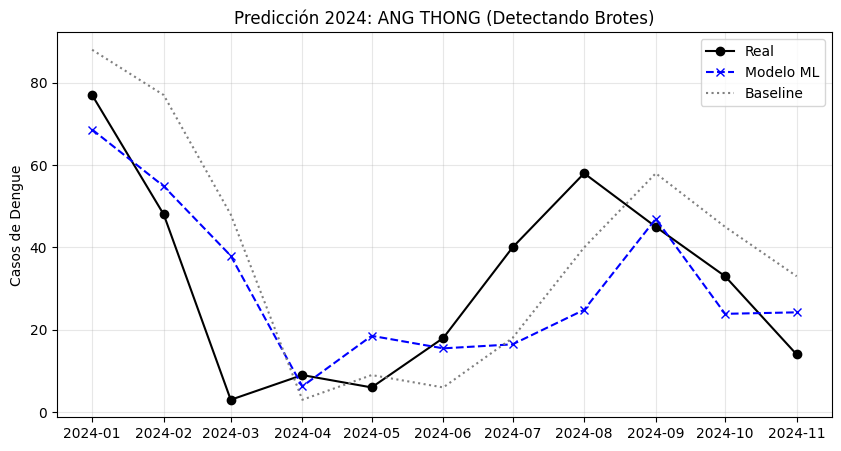

In [7]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import libpysal 
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==============================================================================
# 1. CONFIGURACIÓN
# ==============================================================================
SHP_PATH = "backend/data/geo_thailand/province_dd.shp"
CASES_PATH = "backend/data/DengueThailand_2003-2024_Monthly.xlsx"
CLIMA_PATH = "backend/data/clima_thai.csv"

# Target: Predecir el cambio logarítmico (Tendencia)
TARGET_COL = "y_change_t1" 

print("--- 1. CARGANDO Y PREPARANDO DATOS ---")

# A) Casos
df = pd.read_excel(CASES_PATH)
df = df.melt(id_vars=['Date'], var_name='province', value_name='cases')
df['date'] = pd.to_datetime(df['Date'])
df['province'] = df['province'].astype(str).str.strip().str.upper()
df['cases'] = pd.to_numeric(df['cases'], errors='coerce').fillna(0)

# B) Clima
clima = pd.read_csv(CLIMA_PATH)
clima['date'] = pd.to_datetime(clima['date'])
col_adm = 'ADM1_NAME' if 'ADM1_NAME' in clima.columns else 'province'
clima['province'] = clima[col_adm].astype(str).str.strip().str.upper()

# C) Diccionario de Corrección (Vital para que cruce)
correcciones = {
    'AYUTTHAYA': 'PHRA NAKHON SI AYUTTHAYA', 'BANGKOK': 'KRUNG THEP MAHA NAKHON (BANGKOK)',
    'CHAI NAT': 'CHAINAT', 'BUNGKAN': 'BUENG KAN', 'BURI RAM': 'BURIRAM',
    'CHON BURI': 'CHONBURI', 'LOP BURI': 'LOPBURI', 'NONG BUA LAM PHU': 'NONG BUA LAMPHU',
    'PHANGNGA': 'PHANG NGA', 'PRACHIN BURI': 'PRACHINBURI', 'SI SA KET': 'SISAKET'
}
df['province'] = df['province'].replace(correcciones)
clima['province'] = clima['province'].replace(correcciones)

# D) Merge Inicial
df = df.merge(clima, on=['date', 'province'], how='left')
df = df.sort_values(['province', 'date']).reset_index(drop=True)

# Interpolación de clima (rellenar huecos)
cols_clima = ['temp_c', 'rh_mean', 'total_precipitation_sum']
df[cols_clima] = df.groupby('province')[cols_clima].transform(lambda x: x.interpolate().bfill().ffill())

# ==============================================================================
# 2. INGENIERÍA DE VECINOS (SHAPEFILE)
# ==============================================================================
print("--- 2. CALCULANDO INFLUENCIA DE VECINOS ---")
try:
    gdf = gpd.read_file(SHP_PATH)
    col_mapa = 'PROV_NAME' if 'PROV_NAME' in gdf.columns else gdf.columns[1]
    gdf['province'] = gdf[col_mapa].astype(str).str.strip().str.upper()
    gdf = gdf.set_index('province')
    
    # Pesos Espaciales (Queen)
    w = libpysal.weights.Queen.from_dataframe(gdf, use_index=True)
    # w = libpysal.weights.KNN.from_dataframe(gdf, k=2)
    # Matriz de Casos (Fechas x Provincias)
    pivot_cases = df.pivot(index='date', columns='province', values='cases').fillna(0)
    common = [c for c in pivot_cases.columns if c in w.neighbors]
    
    # Calcular Lag Espacial (Promedio de casos de vecinos)
    w_subset = libpysal.weights.w_subset(w, common)
    w_subset.transform = 'r' # Row-standardized (promedio)
    
    spatial_lag = pd.DataFrame(
        np.dot(pivot_cases[common].values, w_subset.full()[0]),
        index=pivot_cases.index, columns=common
    ).reset_index().melt(id_vars='date', var_name='province', value_name='vecinos_cases')
    
    df = df.merge(spatial_lag, on=['date', 'province'], how='left')
    df['vecinos_cases'] = df['vecinos_cases'].fillna(0)
    print("   ✅ Vecinos calculados correctamente.")
except Exception as e:
    print(f"   ⚠️ Error con vecinos ({e}). Usando 0.")
    df['vecinos_cases'] = 0

# ==============================================================================
# 3. CREACIÓN DEL TARGET Y FEATURES (LAG)
# ==============================================================================
print("--- 3. CREANDO TARGET Y FEATURES TEMPORALES ---")

# A) TARGET: Cambio Logarítmico Futuro (t+1)
# log(casos_futuros + 1) - log(casos_actuales + 1)
df['log_cases'] = np.log1p(df['cases'])
df['y_change_t1'] = df.groupby('province')['log_cases'].shift(-1) - df['log_cases']

# B) FEATURES (Lags Pasados)
lags = [1, 2, 3]
for l in lags:
    # Cambio logarítmico pasado (Momentum)
    df[f'change_t-{l}'] = df.groupby('province')['log_cases'].shift(l) - df.groupby('province')['log_cases'].shift(l+1)
    # Clima pasado (El mosquito tarda 1-2 meses en criar)
    df[f'temp_t-{l}'] = df.groupby('province')['temp_c'].shift(l)
    df[f'rain_t-{l}'] = df.groupby('province')['total_precipitation_sum'].shift(l)
    # Vecinos pasado (Difusión espacial)
    df[f'vecinos_t-{l}'] = np.log1p(df.groupby('province')['vecinos_cases'].shift(l))

# Variables Calendario
df['month'] = df['date'].dt.month
df['sin_month'] = np.sin(2 * np.pi * df['month']/12)
df['cos_month'] = np.cos(2 * np.pi * df['month']/12)
# Limpieza final
df_model = df.dropna().copy()

# ==============================================================================
# 4. ENTRENAMIENTO Y EVALUACIÓN "ANTI-BROTES"
# ==============================================================================
print("--- 4. ENTRENANDO MODELO... ---")

# Split Temporal (Entrenar hasta 2023, Testear en 2024)
train = df_model[df_model['date'].dt.year < 2024]
test = df_model[df_model['date'].dt.year == 2024]

features = [c for c in df_model.columns if 't-' in c or c == 'month']
X_train, y_train = train[features], train[TARGET_COL]
X_test, y_test = test[features], test[TARGET_COL]

# A) MODELO ML
model = HistGradientBoostingRegressor(random_state=42, max_iter=200)
# Damos más peso a los registros con cambios bruscos en el train (para que aprenda brotes)
weights = np.abs(y_train) + 1 
model.fit(X_train, y_train, sample_weight=weights)
pred_model = model.predict(X_test)

# B) BASELINE (Persistencia: "El cambio será 0", o sea, mismos casos que el mes pasado)
pred_base = np.zeros_like(pred_model)

# ==============================================================================
# 5. REPORTE DE RESULTADOS
# ==============================================================================
def report(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return f"{name} -> RMSE: {rmse:.4f} | MAE: {mae:.4f}"

print("\n" + "="*40)
print("RESULTADOS GLOBALES (Todo 2024)")
print("="*40)
print(report(y_test, pred_base, "Baseline (Nulo)"))
print(report(y_test, pred_model, "Modelo ML      "))

# --- EVALUACIÓN ESPECIAL DE BROTES (TOP 20%) ---
print("\n" + "="*40)
print("EVALUACIÓN DE BROTES (Top 20% cambios bruscos)")
print("="*40)
# Identificamos dónde ocurrieron los cambios más fuertes en la realidad
umbral = y_test.abs().quantile(0.8)
mask_brote = y_test.abs() >= umbral

y_brote = y_test[mask_brote]
pred_brote_model = pred_model[mask_brote]
pred_brote_base = pred_base[mask_brote]

print(f"Analizando {len(y_brote)} momentos críticos...")
print(report(y_brote, pred_brote_base, "Baseline"))
print(report(y_brote, pred_brote_model, "Modelo ML"))

# Mejora Porcentual en Brotes
rmse_base = np.sqrt(mean_squared_error(y_brote, pred_brote_base))
rmse_model = np.sqrt(mean_squared_error(y_brote, pred_brote_model))
mejora = 100 * (1 - (rmse_model / rmse_base))
print(f"\n🚀 MEJORA EN BROTES: {mejora:.1f}%")

# ==============================================================================
# 6. VISUALIZACIÓN DE EJEMPLO
# ==============================================================================
# Elegimos la provincia con el brote más fuerte de 2024
prov_brote = test.loc[test[TARGET_COL].abs().idxmax(), 'province']
data_plot = test[test['province'] == prov_brote].sort_values('date')

# Reconstruir Casos Reales vs Predichos (Deshacer el logaritmo)
# log_t1 = log_t + change_pred
# casos_t1 = exp(log_t1) - 1
last_log_cases = data_plot['log_cases'] # Este es el valor en 't'
pred_log_change = model.predict(data_plot[features])

# Proyección del modelo
pred_log_cases_t1 = last_log_cases + pred_log_change
pred_cases_reales = np.expm1(pred_log_cases_t1)

# Valor Real t+1 (lo que pasó de verdad)
real_cases_t1 = np.expm1(last_log_cases + data_plot[TARGET_COL])

plt.figure(figsize=(10, 5))
plt.plot(data_plot['date'], real_cases_t1, 'o-', label='Real', color='black')
plt.plot(data_plot['date'], pred_cases_reales, 'x--', label='Modelo ML', color='blue')
# El baseline es simplemente repetir el valor anterior (linea plana si no hubo cambio)
plt.plot(data_plot['date'], np.expm1(last_log_cases), ':', label='Baseline', color='gray')

plt.title(f"Predicción 2024: {prov_brote} (Detectando Brotes)")
plt.ylabel("Casos de Dengue")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

--- 1. PREPARANDO DATOS ---
--- 2. CALCULANDO VECINOS ---
('WARNING: ', 'CHACHOENGSAO', ' is an island (no neighbors)')
('WARNING: ', 'NAKHON RATCHASIMA', ' is an island (no neighbors)')
('WARNING: ', 'SURIN', ' is an island (no neighbors)')
   ✅ Vecinos calculados (Phuket incluido).
--- 4. ENTRENANDO CON PENALIZACIÓN DE BROTES ---


c:\Users\Nainho\miniconda3\envs\licitacion\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
c:\Users\Nainho\miniconda3\envs\licitacion\Lib\site-packages\libpysal\weights\set_operations.py:386: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 3 islands with ids: CHACHOENGSAO, NAKHON RATCHASIMA, SURIN.
  return W(neighbors, id_order=list(ids), **kwargs)



🚀 MEJORA EN BROTES (Top 20%): 32.2%
Error Baseline: 1.1314
Error Modelo:   0.7670


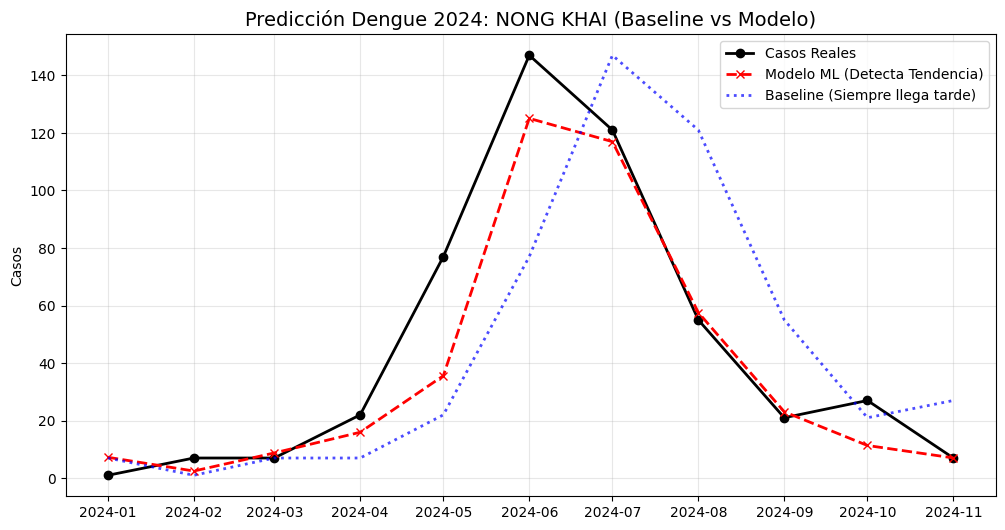

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import libpysal 
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ==============================================================================
# 1. CONFIGURACIÓN
# ==============================================================================
SHP_PATH = "backend/data/geo_thailand/province_dd.shp"
CASES_PATH = "backend/data/DengueThailand_2003-2024_Monthly.xlsx"
CLIMA_PATH = "backend/data/clima_thai.csv"
TARGET_COL = "y_change_t1" 

print("--- 1. PREPARANDO DATOS ---")

# A) Carga y Limpieza de Casos
df = pd.read_excel(CASES_PATH).melt(id_vars=['Date'], var_name='province', value_name='cases')
df['date'] = pd.to_datetime(df['Date'])
df['province'] = df['province'].astype(str).str.strip().str.upper()
df['cases'] = pd.to_numeric(df['cases'], errors='coerce').fillna(0)

# B) Carga y Limpieza de Clima
clima = pd.read_csv(CLIMA_PATH)
clima['date'] = pd.to_datetime(clima['date'])
col_adm = 'ADM1_NAME' if 'ADM1_NAME' in clima.columns else 'province'
clima['province'] = clima[col_adm].astype(str).str.strip().str.upper()

# C) Diccionario de Correcciones (Vital para cruzar datos)
correcciones = {
    'AYUTTHAYA': 'PHRA NAKHON SI AYUTTHAYA', 'BANGKOK': 'KRUNG THEP MAHA NAKHON (BANGKOK)',
    'CHAI NAT': 'CHAINAT', 'BUNGKAN': 'BUENG KAN', 'BURI RAM': 'BURIRAM',
    'CHON BURI': 'CHONBURI', 'LOP BURI': 'LOPBURI', 'NONG BUA LAM PHU': 'NONG BUA LAMPHU',
    'PHANGNGA': 'PHANG NGA', 'PRACHIN BURI': 'PRACHINBURI', 'SI SA KET': 'SISAKET'
}
df['province'] = df['province'].replace(correcciones)
clima['province'] = clima['province'].replace(correcciones)

# D) Merge (Casos + Clima)
df = df.merge(clima, on=['date', 'province'], how='left')
cols_clima = ['temp_c', 'rh_mean', 'total_precipitation_sum']
# Rellenar huecos de clima interpolando
df[cols_clima] = df.groupby('province')[cols_clima].transform(lambda x: x.interpolate().bfill().ffill())

# ==============================================================================
# 2. VECINOS (CORRECCIÓN ISLA PHUKET CON KNN)
# ==============================================================================
print("--- 2. CALCULANDO VECINOS ---")
try:
    gdf = gpd.read_file(SHP_PATH)
    col_mapa = 'PROV_NAME' if 'PROV_NAME' in gdf.columns else gdf.columns[1]
    gdf['province'] = gdf[col_mapa].astype(str).str.strip().str.upper()
    gdf = gdf.set_index('province')
    
    # USAMOS KNN (k=2) EN LUGAR DE QUEEN PARA CONECTAR ISLAS (PHUKET)
    w = libpysal.weights.KNN.from_dataframe(gdf, k=2) 
    
    pivot_cases = df.pivot(index='date', columns='province', values='cases').fillna(0)
    common = [c for c in pivot_cases.columns if c in w.neighbors]
    
    w_subset = libpysal.weights.w_subset(w, common)
    w_subset.transform = 'r' # Row-standardized (promedio)
    
    spatial_lag = pd.DataFrame(
        np.dot(pivot_cases[common].values, w_subset.full()[0]),
        index=pivot_cases.index, columns=common
    ).reset_index().melt(id_vars='date', var_name='province', value_name='vecinos_cases')
    
    df = df.merge(spatial_lag, on=['date', 'province'], how='left')
    df['vecinos_cases'] = df['vecinos_cases'].fillna(0)
    print("   ✅ Vecinos calculados (Phuket incluido).")
except Exception as e:
    print(f"⚠️ Error vecinos: {e}")
    df['vecinos_cases'] = 0

# ==============================================================================
# 3. FEATURE ENGINEERING
# ==============================================================================
# Target: Cambio Logarítmico (Tendencia)
df['log_cases'] = np.log1p(df['cases'])
df['y_change_t1'] = df.groupby('province')['log_cases'].shift(-1) - df['log_cases']

# Lags (Historia Pasada)
for l in [1, 2, 3]:
    # Inercia (cambio pasado)
    df[f'change_t-{l}'] = df.groupby('province')['log_cases'].shift(l) - df.groupby('province')['log_cases'].shift(l+1)
    # Clima (retraso biológico)
    df[f'temp_t-{l}'] = df.groupby('province')['temp_c'].shift(l)
    df[f'rain_t-{l}'] = df.groupby('province')['total_precipitation_sum'].shift(l)
    # Vecinos (riesgo espacial)
    df[f'vecinos_t-{l}'] = np.log1p(df.groupby('province')['vecinos_cases'].shift(l))

# Ciclo Anual (Seno/Coseno)
df['month_sin'] = np.sin(2 * np.pi * df['date'].dt.month/12)
df['month_cos'] = np.cos(2 * np.pi * df['date'].dt.month/12)

df_model = df.dropna().copy()

# ==============================================================================
# 4. ENTRENAMIENTO "MODO ARGENTINA" (PENALIZACIÓN x5)
# ==============================================================================
print("--- 4. ENTRENANDO CON PENALIZACIÓN DE BROTES ---")

# Split Temporal
train = df_model[df_model['date'].dt.year < 2024]
test = df_model[df_model['date'].dt.year == 2024]

features = [c for c in df_model.columns if 't-' in c or 'month_' in c]
X_train, y_train = train[features], train[TARGET_COL]
X_test, y_test = test[features], test[TARGET_COL]

# --- PENALIZACIÓN: PESOS "ANTI-BROTES" ---
# Si el cambio es grande (brote), el peso se multiplica x5
sample_weights = 1 + (y_train.abs() * 5)

model = HistGradientBoostingRegressor(
    max_depth=10,           # Árboles profundos
    learning_rate=0.05,     # Aprendizaje lento y robusto
    max_iter=1000,          # Muchos árboles
    l2_regularization=0.0,
    min_samples_leaf=30,
    loss="squared_error",
    random_state=42
)

model.fit(X_train, y_train, sample_weight=sample_weights)

# Predicciones
pred_model = model.predict(X_test)
pred_base = np.zeros_like(pred_model) # Baseline: El cambio será 0 (Persistencia)

# ==============================================================================
# 5. EVALUACIÓN Y GRÁFICOS
# ==============================================================================
def get_metrics(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# A) Evaluación de Brotes (Top 20% cambios bruscos)
umbral = y_test.abs().quantile(0.8)
mask_brote = y_test.abs() >= umbral

rmse_base = get_metrics(y_test[mask_brote], pred_base[mask_brote])
rmse_model = get_metrics(y_test[mask_brote], pred_model[mask_brote])
mejora = 100 * (1 - (rmse_model / rmse_base))

print("\n" + "="*40)
print(f"🚀 MEJORA EN BROTES (Top 20%): {mejora:.1f}%")
print("="*40)
print(f"Error Baseline: {rmse_base:.4f}")
print(f"Error Modelo:   {rmse_model:.4f}")

# B) Gráfico Comparativo
# Buscamos la provincia con más actividad en 2024
top_prov = test.groupby('province')[TARGET_COL].apply(lambda x: x.abs().sum()).idxmax()
d_plot = test[test['province'] == top_prov].sort_values('date')

# Reconstruir valores reales desde logaritmos
last_log = d_plot['log_cases']
real_vals = np.expm1(last_log + d_plot[TARGET_COL]) # Real t+1
pred_vals = np.expm1(last_log + model.predict(d_plot[features])) # Predicción
base_vals = np.expm1(last_log) # Baseline (repetir valor anterior)

plt.figure(figsize=(12, 6))
plt.plot(d_plot['date'], real_vals, 'k-o', label='Casos Reales', linewidth=2)
plt.plot(d_plot['date'], pred_vals, 'r--x', label='Modelo ML (Detecta Tendencia)', linewidth=2)
plt.plot(d_plot['date'], base_vals, 'b:', label='Baseline', linewidth=2, alpha=0.7)

plt.title(f"Predicción Dengue 2024: {top_prov} (Baseline vs Modelo)", fontsize=14)
plt.ylabel("Casos")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

--- 1. PREPARANDO DATOS ---
--- 2. CALCULANDO VECINOS ---
('WARNING: ', 'CHACHOENGSAO', ' is an island (no neighbors)')
('WARNING: ', 'NAKHON RATCHASIMA', ' is an island (no neighbors)')
('WARNING: ', 'SURIN', ' is an island (no neighbors)')
--- 4. ENTRENANDO Y EVALUANDO (Validación 2024) ---


c:\Users\Nainho\miniconda3\envs\licitacion\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
c:\Users\Nainho\miniconda3\envs\licitacion\Lib\site-packages\libpysal\weights\set_operations.py:386: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 3 islands with ids: CHACHOENGSAO, NAKHON RATCHASIMA, SURIN.
  return W(neighbors, id_order=list(ids), **kwargs)



📊 RESULTADOS GLOBALES (2024)
Métrica    | Baseline   | Modelo ML  | Mejora
--------------------------------------------------
RMSE       | 0.6367     | 0.5492     | 13.7%
MAE        | 0.5127     | 0.4101     | 20.0%
R2         | -0.0327     | 0.2316     | -

🔥 RESULTADOS EN BROTES (Top 20% cambios)
RMSE       | 1.1314     | 0.7670     | 32.2%
MAE        | 1.0977     | 0.6007     | 45.3%
R2         | -0.0388     | 0.5226     | -


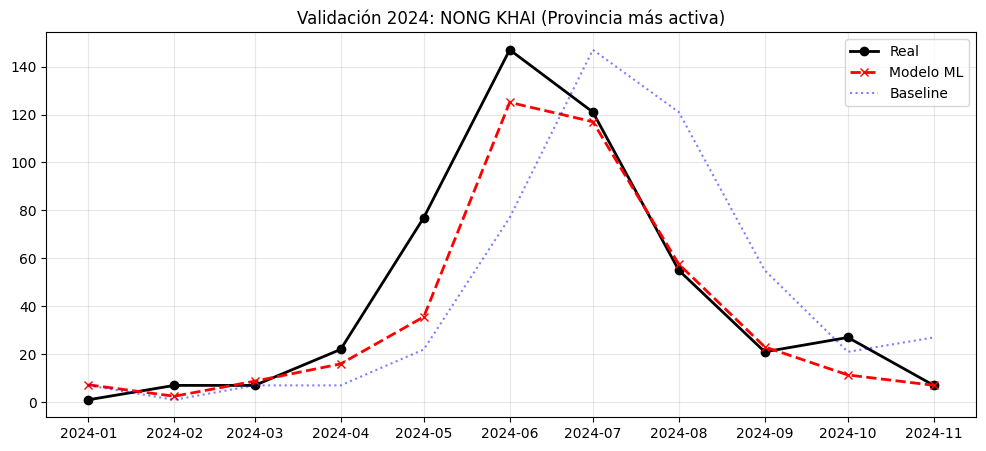

In [22]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import libpysal 
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==============================================================================
# 1. CONFIGURACIÓN Y CARGA
# ==============================================================================
SHP_PATH = "backend/data/geo_thailand/province_dd.shp"
CASES_PATH = "backend/data/DengueThailand_2003-2024_Monthly.xlsx"
CLIMA_PATH = "backend/data/clima_thai.csv"
TARGET_COL = "y_change_t1" 

print("--- 1. PREPARANDO DATOS ---")

# A) Carga Casos
df = pd.read_excel(CASES_PATH).melt(id_vars=['Date'], var_name='province', value_name='cases')
df['date'] = pd.to_datetime(df['Date'])
df['province'] = df['province'].astype(str).str.strip().str.upper()
df['cases'] = pd.to_numeric(df['cases'], errors='coerce').fillna(0)

# B) Carga Clima
clima = pd.read_csv(CLIMA_PATH)
clima['date'] = pd.to_datetime(clima['date'])
col_adm = 'ADM1_NAME' if 'ADM1_NAME' in clima.columns else 'province'
clima['province'] = clima[col_adm].astype(str).str.strip().str.upper()

# C) Correcciones de Nombres
correcciones = {
    'AYUTTHAYA': 'PHRA NAKHON SI AYUTTHAYA', 'BANGKOK': 'KRUNG THEP MAHA NAKHON (BANGKOK)',
    'CHAI NAT': 'CHAINAT', 'BUNGKAN': 'BUENG KAN', 'BURI RAM': 'BURIRAM',
    'CHON BURI': 'CHONBURI', 'LOP BURI': 'LOPBURI', 'NONG BUA LAM PHU': 'NONG BUA LAMPHU',
    'PHANGNGA': 'PHANG NGA', 'PRACHIN BURI': 'PRACHINBURI', 'SI SA KET': 'SISAKET'
}
df['province'] = df['province'].replace(correcciones)
clima['province'] = clima['province'].replace(correcciones)

# D) Merge
df = df.merge(clima, on=['date', 'province'], how='left')
cols_clima = ['temp_c', 'rh_mean', 'total_precipitation_sum']
df[cols_clima] = df.groupby('province')[cols_clima].transform(lambda x: x.interpolate().bfill().ffill())

# ==============================================================================
# 2. VECINOS (KNN k=2)
# ==============================================================================
print("--- 2. CALCULANDO VECINOS ---")
try:
    gdf = gpd.read_file(SHP_PATH)
    col_mapa = 'PROV_NAME' if 'PROV_NAME' in gdf.columns else gdf.columns[1]
    gdf['province'] = gdf[col_mapa].astype(str).str.strip().str.upper()
    gdf = gdf.set_index('province')
    
    # KNN k=2 para conectar Phuket
    w = libpysal.weights.KNN.from_dataframe(gdf, k=2) 
    
    pivot_cases = df.pivot(index='date', columns='province', values='cases').fillna(0)
    common = [c for c in pivot_cases.columns if c in w.neighbors]
    
    w_subset = libpysal.weights.w_subset(w, common)
    w_subset.transform = 'r'
    
    spatial_lag = pd.DataFrame(
        np.dot(pivot_cases[common].values, w_subset.full()[0]),
        index=pivot_cases.index, columns=common
    ).reset_index().melt(id_vars='date', var_name='province', value_name='vecinos_cases')
    
    df = df.merge(spatial_lag, on=['date', 'province'], how='left')
    df['vecinos_cases'] = df['vecinos_cases'].fillna(0)
except Exception as e:
    print(f"⚠️ Error vecinos: {e}")
    df['vecinos_cases'] = 0

# ==============================================================================
# 3. FEATURE ENGINEERING
# ==============================================================================
df['log_cases'] = np.log1p(df['cases'])
df['y_change_t1'] = df.groupby('province')['log_cases'].shift(-1) - df['log_cases']

for l in [1, 2, 3]:
    df[f'change_t-{l}'] = df.groupby('province')['log_cases'].shift(l) - df.groupby('province')['log_cases'].shift(l+1)
    df[f'temp_t-{l}'] = df.groupby('province')['temp_c'].shift(l)
    df[f'rain_t-{l}'] = df.groupby('province')['total_precipitation_sum'].shift(l)
    df[f'vecinos_t-{l}'] = np.log1p(df.groupby('province')['vecinos_cases'].shift(l))

df['month_sin'] = np.sin(2 * np.pi * df['date'].dt.month/12)
df['month_cos'] = np.cos(2 * np.pi * df['date'].dt.month/12)

df_model = df.dropna().copy()

# ==============================================================================
# 4. VALIDACIÓN CRUZADA TEMPORAL (Test 2024)
# ==============================================================================
print("--- 4. ENTRENANDO Y EVALUANDO (Validación 2024) ---")

train = df_model[df_model['date'].dt.year < 2024]
test = df_model[df_model['date'].dt.year == 2024]

features = [c for c in df_model.columns if 't-' in c or 'month_' in c]
X_train, y_train = train[features], train[TARGET_COL]
X_test, y_test = test[features], test[TARGET_COL]

# Penalización x5
sample_weights = 1 + (y_train.abs() * 5)

model = HistGradientBoostingRegressor(
    max_depth=10, learning_rate=0.05, max_iter=1000,
    l2_regularization=0.0, min_samples_leaf=30, loss="squared_error", random_state=42
)

model.fit(X_train, y_train, sample_weight=sample_weights)

pred_model = model.predict(X_test)
pred_base = np.zeros_like(pred_model)

# --- MÉTRICAS ---
def get_metrics(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

# Globales
m_base = get_metrics(y_test, pred_base)
m_model = get_metrics(y_test, pred_model)

print("\n" + "="*50)
print("📊 RESULTADOS GLOBALES (2024)")
print("="*50)
print(f"{'Métrica':<10} | {'Baseline':<10} | {'Modelo ML':<10} | {'Mejora'}")
print("-" * 50)
print(f"{'RMSE':<10} | {m_base['RMSE']:.4f}     | {m_model['RMSE']:.4f}     | {100*(1-m_model['RMSE']/m_base['RMSE']):.1f}%")
print(f"{'MAE':<10} | {m_base['MAE']:.4f}     | {m_model['MAE']:.4f}     | {100*(1-m_model['MAE']/m_base['MAE']):.1f}%")
print(f"{'R2':<10} | {m_base['R2']:.4f}     | {m_model['R2']:.4f}     | -")

# Brotes
umbral = y_test.abs().quantile(0.8)
mask_brote = y_test.abs() >= umbral
mb_base = get_metrics(y_test[mask_brote], pred_base[mask_brote])
mb_model = get_metrics(y_test[mask_brote], pred_model[mask_brote])

print("\n" + "="*50)
print("🔥 RESULTADOS EN BROTES (Top 20% cambios)")
print("="*50)
print(f"{'RMSE':<10} | {mb_base['RMSE']:.4f}     | {mb_model['RMSE']:.4f}     | {100*(1-mb_model['RMSE']/mb_base['RMSE']):.1f}%")
print(f"{'MAE':<10} | {mb_base['MAE']:.4f}     | {mb_model['MAE']:.4f}     | {100*(1-mb_model['MAE']/mb_base['MAE']):.1f}%")
print(f"{'R2':<10} | {mb_base['R2']:.4f}     | {mb_model['R2']:.4f}     | -")


# --- GRÁFICO VALIDACIÓN 2024 ---
top_prov = test.groupby('province')[TARGET_COL].apply(lambda x: x.abs().sum()).idxmax()
d_plot = test[test['province'] == top_prov].sort_values('date')

real_vals = np.expm1(d_plot['log_cases'] + d_plot[TARGET_COL])
pred_vals = np.expm1(d_plot['log_cases'] + model.predict(d_plot[features]))
base_vals = np.expm1(d_plot['log_cases'])

plt.figure(figsize=(12, 5))
plt.plot(d_plot['date'], real_vals, 'k-o', label='Real', linewidth=2)
plt.plot(d_plot['date'], pred_vals, 'r--x', label='Modelo ML', linewidth=2)
plt.plot(d_plot['date'], base_vals, 'b:', label='Baseline', alpha=0.5)
plt.title(f"Validación 2024: {top_prov} (Provincia más activa)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



🏭 ENTRENANDO MODELO DE PRODUCCIÓN (TODA LA HISTORIA)
✅ Modelo entrenado con 100% de datos.


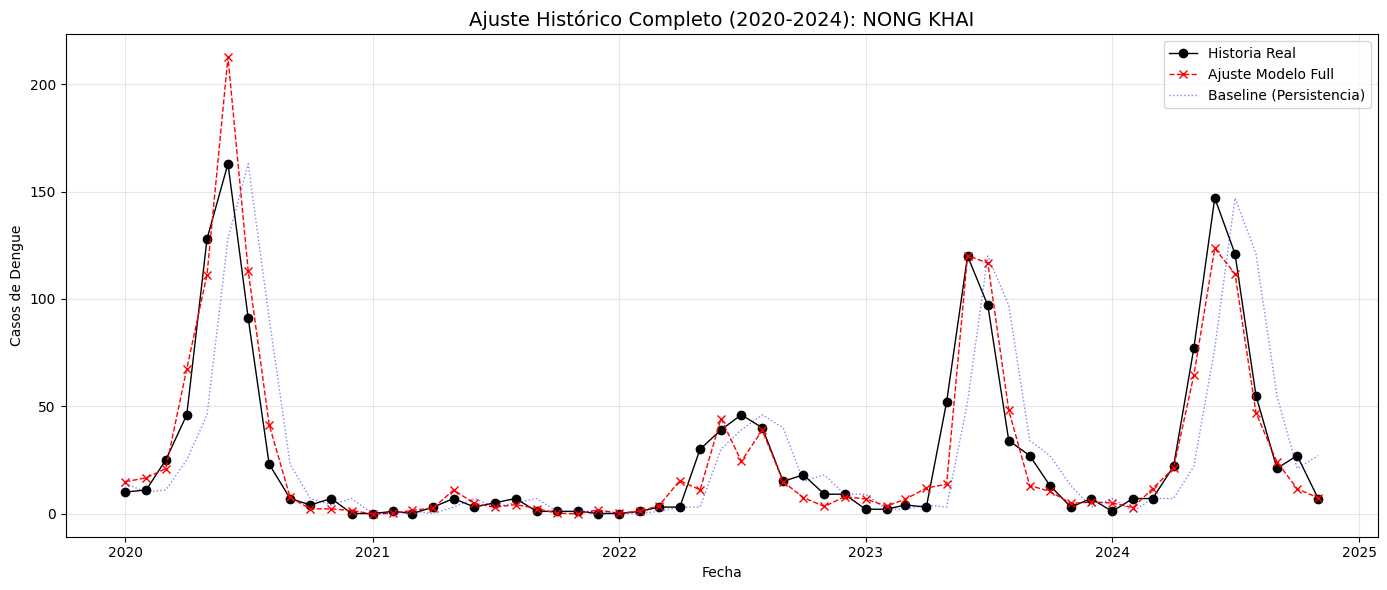

In [24]:
# ==============================================================================
# 5. MODELO DE PRODUCCIÓN (Full Training)
# ==============================================================================
print("\n" + "="*50)
print("🏭 ENTRENANDO MODELO DE PRODUCCIÓN (TODA LA HISTORIA)")
print("="*50)

# 1. Entrenar con TODO el dataset (sin separar train/test)
X_full = df_model[features]
y_full = df_model[TARGET_COL]

# Pesos para priorizar brotes en toda la historia
w_full = 1 + (y_full.abs() * 5)

model_prod = HistGradientBoostingRegressor(
    max_depth=10, learning_rate=0.05, max_iter=1000,
    l2_regularization=0.0, min_samples_leaf=30, loss="squared_error", random_state=42
)
model_prod.fit(X_full, y_full, sample_weight=w_full)

print("✅ Modelo entrenado con 100% de datos.")

# --- GRÁFICO DE AJUSTE HISTÓRICO ---
# Usamos la misma provincia 'top_prov' para ver cómo se ajustó el modelo a toda su historia
d_hist = df_model[df_model['province'] == top_prov].sort_values('date')

# Filtramos desde 2010 para ver detalle, pero usando el modelo full
a_partir_año = 2020
d_hist = d_hist[d_hist['date'].dt.year >= a_partir_año] 

# 1. VALOR REAL (t+1)
real_hist = np.expm1(d_hist['log_cases'] + d_hist[TARGET_COL])

# 2. MODELO ML (t+1) - Predicción "In-Sample"
pred_hist = np.expm1(d_hist['log_cases'] + model_prod.predict(d_hist[features]))

# 3. BASELINE (t+1) - Persistencia
base_hist = np.expm1(d_hist['log_cases'])

plt.figure(figsize=(14, 6))

# Usamos EXACTAMENTE los mismos estilos que en la validación
plt.plot(d_hist['date'], real_hist, 'k-o', label='Historia Real', linewidth=1)
plt.plot(d_hist['date'], pred_hist, 'r--x', label='Ajuste Modelo Full', linewidth=1)
plt.plot(d_hist['date'], base_hist, 'b:', label='Baseline (Persistencia)', alpha=0.5, linewidth=1)

plt.title(f"Ajuste Histórico Completo ({a_partir_año}-2024): {top_prov}", fontsize=14)
plt.ylabel("Casos de Dengue")
plt.xlabel("Fecha")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
X_full

,change_t-1,temp_t-1,rain_t-1,vecinos_t-1,change_t-2,temp_t-2,rain_t-2,vecinos_t-2,change_t-3,temp_t-3,rain_t-3,vecinos_t-3,month_sin,month_cos
4,0.751416,29.417105,0.074617,5.940171,1.832581,26.755043,0.060445,5.808142,-0.916291,26.014932,0.016480,4.799914,5.000000e-01,-8.660254e-01
5,0.360441,28.790411,0.242831,6.530878,0.751416,29.417105,0.074617,5.940171,1.832581,26.755043,0.060445,5.808142,1.224647e-16,-1.000000e+00
6,0.567106,27.433142,0.205642,6.679599,0.360441,28.790411,0.242831,6.530878,0.751416,29.417105,0.074617,5.940171,-5.000000e-01,-8.660254e-01
7,-0.754705,27.226600,0.180670,6.233430,0.567106,27.433142,0.205642,6.679599,0.360441,28.790411,0.242831,6.530878,-8.660254e-01,-5.000000e-01
8,-1.098612,26.488779,0.295339,5.695414,-0.754705,27.226600,0.180670,6.233430,0.567106,27.433142,0.205642,6.679599,-1.000000e+00,-1.836970e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20322,1.386294,28.617069,0.135787,4.639572,-0.054067,29.893357,0.207072,3.540959,-0.387766,33.376208,0.001618,3.970292,-5.000000e-01,-8.660254e-01
20323,-0.102279,26.876840,0.388670,4.828314,1.386294,28.617069,0.135787,4.639572,-0.054067,29.893357,0.207072,3.540959,-8.660254e-01,-5.000000e-01
20324,0.102279,27.765262,0.180940,5.068904,-0.102279,26.876840,0.388670,4.828314,1.386294,28.617069,0.135787,4.639572,-1.000000e+00,-1.836970e-16
20325,-0.944462,26.919326,0.297500,4.262680,0.102279,27.765262,0.180940,5.068904,-0.102279,26.876840,0.388670,4.828314,-8.660254e-01,5.000000e-01
